### Lab 2: Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
!pip install subword-nmt
!pip install pytorch-nlp

     |████████████████████████████████| 90 kB 3.8 MB/s 


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/MADE/nlp/lab2/my_network.py' .
!cp '/content/drive/MyDrive/MADE/nlp/lab2/utils.py' .
!cp '/content/drive/MyDrive/MADE/nlp/lab2/cnn_utils.py' .
!cp '/content/drive/MyDrive/MADE/nlp/lab2/data.txt' .
!cp '/content/drive/MyDrive/MADE/nlp/lab2/bidirectional.py' .
!cp '/content/drive/MyDrive/MADE/nlp/lab2/attention.py' .
!cp '/content/drive/MyDrive/MADE/nlp/lab2/bidirectional_attention.py' .
!cp '/content/drive/MyDrive/MADE/nlp/lab2/cnn.py' .
path_to_data = '/content/data.txt'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = TabularDataset(
    path=path_to_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [ ]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9313
Unique tokens in target (en) vocabulary: 6777


Here are tokens from original (RU) corpus:

In [ ]:
SRC.vocab.itos[::1000]

['<unk>',
 'поездки',
 'американской',
 'катере',
 '2010',
 'шезлонга',
 'julia',
 'финского',
 'зеленую',
 'трамвай']

And from target (EN) corpus:

In [ ]:
TRG.vocab.itos[::1000]

['<unk>', 'capital', 'gateway', 'chelsea', 'mondsee', 'smoked', 'maintaining']

And here is example from train dataset:

In [ ]:
print(vars(train_data.examples[9]))

{'trg': ['all', 'apartments', 'have', 'modern', 'décor', 'and', 'parquet', 'floors', '.'], 'src': ['апартаменты', 'с', 'паркетным', 'полом', 'оформлены', 'в', 'современном', 'стиле', '.']}


Let's check the length distributions:

Length distribution in Train data


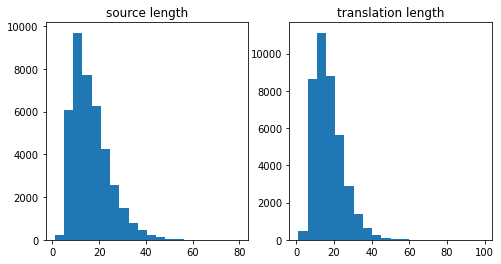

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


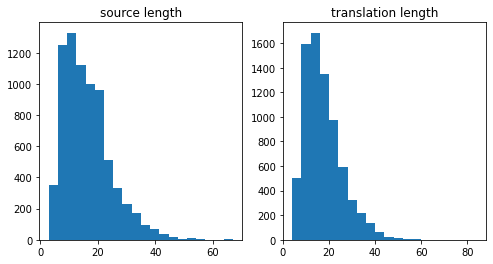

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model 1. Baseline LSTM model
__Provided baseline LSTM model with a BLEU score of ~14.__

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cpu')

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.legacy.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 42x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 40x128 (GPU 0)]
torch.Size([40, 128]) torch.Size([42, 128])


In [ ]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9313, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6777, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6777, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,952,057 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        import pdb
        pdb.set_trace()
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/bdb.py", line 332, in set_trace
    sys.settrace(self.trace_dispatch)



> <ipython-input-18-a29880e8f6a2>(20)train()
-> output = output[1:].view(-1, output.shape[-1])
(Pdb) trg.shape
torch.Size([58, 128])
(Pdb) output.shape
torch.Size([58, 128, 6777])
(Pdb) trg
tensor([[  2,   2,   2,  ...,   2,   2,   2],
        [ 30,   6,  15,  ..., 145,  15,  51],
        [ 90, 543,  41,  ...,  46, 715,  68],
        ...,
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1]])
(Pdb) batch.shape
*** AttributeError: 'Batch' object has no attribute 'shape'
(Pdb) src.shape
torch.Size([51, 128])
(Pdb) trg[0]
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/bdb.py", line 357, in set_quit
    sys.settrace(None)



BdbQuit: ignored

__Let's take a look at our network quality__:

In [ ]:
del utils

In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
%%time 
for idx in range(1, 20):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: breakfast is provided every morning .
Generated: scottish breakfast .

Original: each room has a balcony .
Generated: all all units have a private bathroom .

Original: front desk is open 24 hours .
Generated: desk .

Original: massages can be arranged .
Generated: the .

Original: you will find a 24 - hour front desk at the property .
Generated: desk .

Original: rooms are equipped with a tv .
Generated: all rooms are equipped with a hairdryer .

Original: the property offers free parking .
Generated: free parking parking is available on site .

Original: there is a 24 - hour front desk at the property .
Generated: desk .

Original: the property offers free parking .
Generated: free parking parking is available on site .

Original: the property offers free parking .
Generated: free parking parking is available on site .

Original: the property offers free parking .
Generated: free parking parking is available on site .

Original: all the rooms have balconies .
Generated: all

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [ ]:
import tqdm

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:03, 16.80it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

14.337652694279079

### Model 2. Bidirectional LSTM.
__Bidirectional 4 layer LSTM model. I experimented with weight initialization but it didn't give any improvements. I trained the model for 40 epochs. Added weight decay to counteract overfitting. Also, added scheduler to enhance training. BLEU score ~19.__

In [ ]:
import bidirectional as my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 4
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    # added Xavier initialization, but it didn't give any serious improvements
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.1, 0.1)
        #if param.dim() > 1:
        #    nn.init.xavier_normal_(param, gain=1.0)
        #else:
        #    nn.init.uniform_(param, a=-0.1, b=0.1)
        
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9255, 256)
    (rnn): LSTM(256, 512, num_layers=4, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (out_hidden): Linear(in_features=1024, out_features=512, bias=True)
    (out_cell): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(6688, 256)
    (rnn): LSTM(256, 512, num_layers=4, dropout=0.5)
    (out): Linear(in_features=512, out_features=6688, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 38,495,520 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 40
CLIP = 1

best_valid_loss = float('inf')

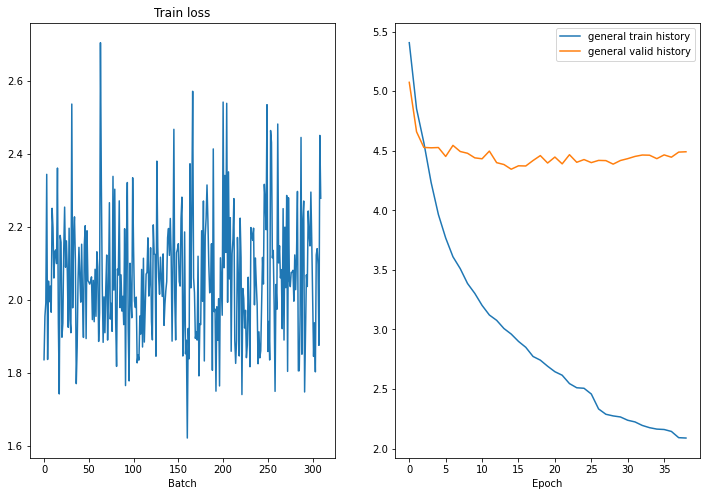

Epoch: 40 | Time: 2m 24s
	Train Loss: 2.060 | Train PPL:   7.844
	 Val. Loss: 4.492 |  Val. PPL:  89.310


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    scheduler.step(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
%%time 
for idx in range(1, 20):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: you will find a kettle in the room .
Generated: you will find a kettle in the room .

Original: private parking is free .
Generated: free private parking is available on site .

Original: a front desk is at your service for 24 hours .
Generated: there is a 24 - hour front desk at the property .

Original: breakfast can also be ordered there .
Generated: guests can enjoy a breakfast breakfast .

Original: there is a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk at the property .

Original: there is a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk at the property .

Original: guests benefit from terrace .
Generated: guests benefit from terrace .

Original: private parking is free .
Generated: free private parking is available on site .

Original: massages can be arranged .
Generated: guests can also be arranged on request .

Original: parking is free .
Generated: free parking is available .

Original: breakf

In [ ]:
%%time 
for idx in range(20, 40):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: you will find a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk at the property .

Original: guests can enjoy the on - site restaurant .
Generated: there can enjoy a restaurant on site restaurant .

Original: the comfortable apartment has a balcony .
Generated: the apartment offers a balcony and a balcony .

Original: the spacious rooms are all air - conditioned .
Generated: the air - conditioned rooms are air - conditioned .

Original: the property offers free parking .
Generated: free private parking is available on site .

Original: daily maid service is available .
Generated: daily maid service is available for an extra fee .

Original: rooms are also heated and have a safe .
Generated: the rooms are equipped with a fan and a .

Original: you will find a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk at the property .

Original: you will find a 24 - hour front desk at the property .
Generated: there is a

In [ ]:
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

batch = next(iter(test_iterator))

original_text = []
generated_text = []
model.load_state_dict(torch.load('tut1-model.pt'))
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

corpus_bleu([[text] for text in original_text], generated_text) * 100

59it [00:04, 12.34it/s]


18.936132826055555

### Model 3. LSTM with Attention.
__I added attention mechanism to baseline LSTM network. I trained for 30 epochs. And made the weight initialization spectrum a bit wider (-0.2, 0.2). BLEU score ~22.__

In [ ]:
import attention as my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.2, 0.2)        
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9215, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
    (out_output): Linear(in_features=512, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (linear_in): Linear(in_features=512, out_features=512, bias=False)
      (linear_out): Linear(in_features=1024, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (embedding): Embedding(6676, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6676, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,898,388 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 30
CLIP = 1

best_valid_loss = float('inf')

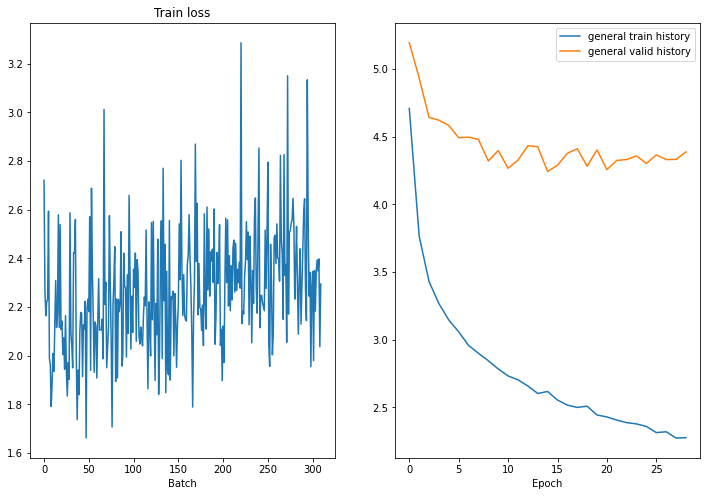

Epoch: 30 | Time: 1m 23s
	Train Loss: 2.264 | Train PPL:   9.621
	 Val. Loss: 4.392 |  Val. PPL:  80.827


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    #scheduler.step(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
%%time 
for idx in range(1, 20):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: the property offers free parking .
Generated: free parking is available on site .

Original: you will find a 24 - hour front desk at the property .
Generated: you will find a 24 - hour front desk .

Original: guests benefit from balcony .
Generated: accommodation will provide you with a balcony .

Original: the kitchen comes with a dishwasher .
Generated: the kitchen also has a dishwasher .

Original: laundry facilities are also available .
Generated: a washing machine .

Original: there is a 24 - hour front desk .
Generated: you will find a 24 - hour front desk .

Original: there is also a .
Generated: you can play darts at the hotel .

Original: the property offers free parking .
Generated: free parking is available on site .

Original: bed linen is available .
Generated: bed linen .

Original: for your comfort , you will find slippers and a hairdryer .
Generated: bathrobes and slippers and a hairdryer .

Original: staff are available 24 hours a day .
Generated: staff can b

In [ ]:
%%time 
for idx in range(20, 40):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: inn spring inn has a 24 - hour front desk .
Generated: you will find a 24 - hour front desk .

Original: some rooms offer a balcony .
Generated: some rooms have a balcony .

Original: the property offers free parking .
Generated: parking is available on site .

Original: the property offers free parking .
Generated: free parking is available on site .

Original: the 24 - hour front desk also provides basic business services like fax and photocopying .
Generated: you will find a 24 - hour front desk .

Original: you will find a 24 - hour front desk at the property .
Generated: you will find a 24 - hour front desk .

Original: private parking is free .
Generated: private parking is available on site .

Original: there is a 24 - hour front desk at the property .
Generated: you will find a 24 - hour front desk .

Original: a tv is provided .
Generated: a tv is available .

Original: there is a 24 - hour front desk at the property .
Generated: you will find a 24 - hour front desk 

In [ ]:
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

batch = next(iter(test_iterator))

original_text = []
generated_text = []
model.load_state_dict(torch.load('tut1-model.pt'))
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

corpus_bleu([[text] for text in original_text], generated_text) * 100

59it [00:03, 16.70it/s]


22.361513496651803

### Model 4. Bidirectional LSTM with Attention
__Combined bidirectional LSTM with attention mechanism. Additionally added linear layers for additional processing of hidden states. Trained only for 10 epochs and got BLEU score ~30.__

In [ ]:
import bidirectional_attention as my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    # added Xavier initialization
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9212, 256)
    (lstm): LSTM(256, 512, num_layers=2, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6696, 256)
    (lstm): LSTM(256, 512, num_layers=2, dropout=0.5)
    (attention): Attention(
      (linear_in): Linear(in_features=512, out_features=512, bias=False)
      (linear_out): Linear(in_features=1024, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (out): Linear(in_features=1024, out_features=6696, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (linear_long): Linear(in_features=1024, out_features=512, bias=True)
  (linear_short): Linear(in_features=1024, out_features=512, bias=True)
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 25,903,656 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
#optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
optimizer = optim.Adam(model.parameters())

#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=5)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

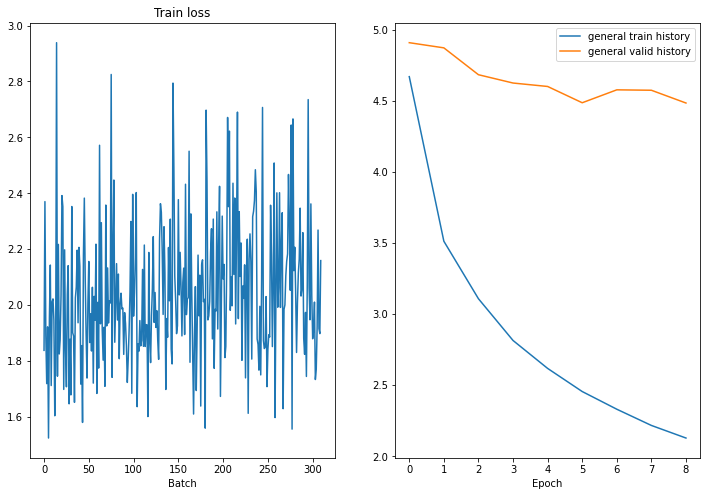

Epoch: 10 | Time: 1m 55s
	Train Loss: 2.043 | Train PPL:   7.716
	 Val. Loss: 4.486 |  Val. PPL:  88.738


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    #scheduler.step(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
%%time 
for idx in range(1, 20):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: a pillow menu is available .
Generated: a daily menu is also available .

Original: inn spring inn has a 24 - hour front desk .
Generated: there is a 24 - hour front desk at the property .

Original: daily maid service is also provided .
Generated: daily maid service is available .

Original: the unit is fitted with a kitchen .
Generated: the unit is equipped with a kitchen .

Original: daily maid service is available .
Generated: daily maid service is provided .

Original: there is the on - site bar at the property .
Generated: guests can enjoy the on - site bar .

Original: the property offers free parking .
Generated: the property offers free parking .

Original: free parking is available on site .
Generated: the property offers free parking .

Original: savoury options are also available upon request .
Generated: breakfast is optional for breakfast . request .

Original: you will find free shuttle service at the property .
Generated: free is free .

Original: the guest ho

In [ ]:
%%time 
for idx in range(20, 40):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: the bathroom comes with a shower .
Generated: the bathroom comes with a shower .

Original: you will find a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk at the property .

Original: guests can enjoy the on - site bar .
Generated: guests can enjoy the on - site bar .

Original: you will find a kettle in the room .
Generated: you will find a kettle in the room .

Original: the reception is open 24 hours a day .
Generated: there is a 24 - hour front desk at the property .

Original: you will find a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk at the property .

Original: you will find a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk at the property .

Original: guests can enjoy the on - site bar .
Generated: guests can enjoy the on - site bar .

Original: bed linen is provided .
Generated: bed linen is featured .

Original: bed linen is provided .
Generated: bed linen is 

In [ ]:
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

batch = next(iter(test_iterator))

original_text = []
generated_text = []
model.load_state_dict(torch.load('tut1-model.pt'))
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

corpus_bleu([[text] for text in original_text], generated_text) * 100

59it [00:04, 14.75it/s]


30.663978615811583

### 5. CNN + Attention
__CNN used along with attention for model translation. I chose kernel size of 3 and got very impressive BLEU result of 92.6! I used the code from some github repo. The problem I had was during training process. I am able to train up to some point after which I get an error regarding out of range index. However, I don't have enough time to debug it.__ 

In [ ]:
import cnn as my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [ ]:
def train_cnn(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        output = model(src.T, trg.T).permute(1, 0, 2)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].reshape(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)


def evaluate_cnn(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src.T, trg.T).permute(1, 0, 2) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].reshape(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
KERNEL_SIZE = 3
PAD_IDX = TRG.vocab.stoi['<pad>']


enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, KERNEL_SIZE, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, KERNEL_SIZE, DEC_DROPOUT, PAD_IDX, device)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec).to(device)

In [ ]:
def init_weights(m):
    # added Xavier initialization
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(9252, 256)
    (pos_embedding): Embedding(100, 256)
    (emb2hid): Linear(in_features=256, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=256, bias=True)
    (convs): ModuleList(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (tok_embedding): Embedding(6696, 256)
    (pos_embedding): Embedding(100, 256)
    (emb2hid): Linear(in_features=256, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=256, bias=True)
    (attn_hid2emb): Linear(in_features=512, out_features=256, bias=True)
    (attn_emb2hid): Linear(in_features=256, out_features=512, bias=True)
    (fc_out): Linear(in_features=256, out_features=6696, bias=True)
    (convs): ModuleList(
      (0): Conv1d(512, 1024, kernel_size=(

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 12,939,048 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
#optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
optimizer = optim.Adam(model.parameters())

#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=5)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 3
CLIP = 1

best_valid_loss = float('inf')

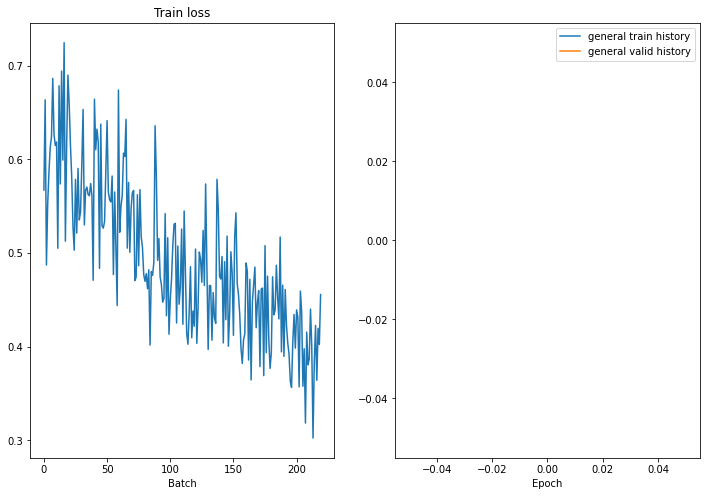

IndexError: ignored

In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train_cnn(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate_cnn(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
import cnn_utils
import imp
imp.reload(cnn_utils)
generate_translation = cnn_utils.generate_translation
remove_tech_tokens = cnn_utils.remove_tech_tokens
get_text = cnn_utils.get_text
flatten = cnn_utils.flatten

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
%%time 
for idx in range(1, 20):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: the property offers free parking .
Generated: the property offers free parking .

Original: there is a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk at the property .

Original: guests can enjoy the on - site bar .
Generated: guests can enjoy the on - site bar .

Original: there is a garden , where guests can relax .
Generated: there is a garden , where guests can relax .

Original: there is a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk at the property .

Original: free parking is provided .
Generated: free parking is provided .

Original: rooms are equipped with a tv .
Generated: rooms are equipped with a tv .

Original: there is a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk at the property .

Original: you will find a kettle in the room .
Generated: you will find a kettle in the room .

Original: the property offers free parking .
Generated: the property offers fr

In [ ]:
batch = next(iter(test_iterator))

original_text = []
generated_text = []
#model.load_state_dict(torch.load('tut1-model.pt'))
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src.T, trg.T).permute(1, 0, 2) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

corpus_bleu([[text] for text in original_text], generated_text) * 100

59it [00:39,  1.51it/s]


92.6660060002285

### Conclusion.
__Unidirectional LSTM model performed very bad because language needs to know the words that come later on as well to perform good. Once I made LSTM bidirectional the results inproved significantly. It has longer training time but similar inference time as LSTM model. Bidirectional LSTM with attention attached to it performed really well. It's training time is short and inference time is a bit longer. I got the best performance from CNN + Attention model which gave BLEU of 92! I got the implementation from public repo and had problems during testing. I need more time to debug, otherwise it performs really well. In general all models overfit. It is noticeable from bad cases of translations as well, where some extra words come from training corpus the model has seen. When I tried adding weight decay for Adam I got worse BLEU score and decided to abandon the idea of using it. Summary of experiments is presented in the table below.__

| Model | BLEU Score | Good Translation Cases | Bad Translation Cases | Model Training Time | Overfitting | Inference Time |
| :- | :- | :- | :- | :- | :- | :- |
| LSTM | 14 | Original: the property offers free parking . <br> Generated: free parking parking is available on site . | Original: each room has a balcony <br> Generated: all all units have a private bathroom . <br><br> Original: massages can be arranged . <br> Generated: the . | ~11 mins | yes | 300 ms
| Bidirectional LSTM | 19 | Original: you will find a kettle in the room <br>Generated: you will find a kettle in the room .<br><br> Original: there is a 24 - hour front desk at the property .<br>Generated: there is a 24 - hour front desk at the property . | Original: massages can be arranged . <br> Generated: guests can also be arranged on request . | ~80 mins | yes | 329 ms
| LSTM + Attention | 22 | Original: you will find a 24 - hour front desk at the property . <br> Generated: there is a 24 - hour front desk at the property . <br><br> Original: the property offers free parking . <br> Generated: the property offers free parking . | Original: laundry facilities are also available . <br> Generated: a washing machine . | ~45 mins | yes | 500 ms
| Bidirectional LSTM + Attention | 30 | Original: the bathroom comes with a shower . <br> Generated: the bathroom comes with a shower . <br><br> Original: guests can enjoy the on - site bar . <br> Generated: guests can enjoy the on - site bar . | Original: free wifi is available . <br> Generated: free wi - fi access is available . this homestay . <br><br> Original: the hotel also offers car hire .<br>Generated: the hotel also offers car hire and laundry services .| ~20 mins | yes | 400 ms
| CNN + Attention | 92 | All of them good | Couldn't find | 1 epoch ~1 min | unknown | 500 ms